In [1]:
%pip install pytorch-lightning > /dev/null
%pip install yfinance > /dev/null
%pip install tqdm numpy pandas pytorch matplotlib

Note: you may need to restart the kernel to use updated packages.


���⥬� �� 㤠���� ���� 㪠����� ����.


Note: you may need to restart the kernel to use updated packages.


���⥬� �� 㤠���� ���� 㪠����� ����.


  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Using cached pandas-1.5.2-cp311-cp311-win_amd64.whl (10.3 MB)
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached matplotlib-3.6.2-cp311-cp311-win_amd64.whl (7.2 MB)
  Using cached contourpy-1.0.6-cp311-cp311-win_amd64.whl (163 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached kiwisolver-1.4.4-cp311-cp311-win_amd64.whl (55 kB)
  Using cached Pillow-9.3.0-cp311-cp311-win_amd64.whl (2.5 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Running setup.py install for pytorch: started
  Running setup.py install for pytorch: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: pytorch is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Windows\Temp\pip-install-0_dhb9_z\pytorch_f95f6b0b02d14053a4ce0f57f4d988fb\setup.py", line 11, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with

In [2]:
from collections import namedtuple, deque, Counter, defaultdict
import random
import os
from itertools import islice

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import pytorch_lightning as pl

import matplotlib.pyplot as plt
# from google.colab import files
import numpy as np
import pandas as pd
from tqdm import tqdm
import yfinance as fin

ModuleNotFoundError: No module named 'torch'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/linearbaby/praktika-datafiles.git praktika

Cloning into 'praktika'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.


Здесь следует внимательно специфицировать пути для работы.

In [ ]:
artifacts_path = "/content/praktika/"   # путь до клонированных артифактов моделек с гита
model_checkpoint_path = '/tmp/'   # сюда будут сохранятся чекпоинты моделек (даже внешней LSTM)
general_lstm_checkpoint = artifacts_path + 'epoch=60-step=26901.ckpt'   # здесь находится чекпоинт внешней LSTM, скачанный с гита

In [ ]:
# Внешняя LSTM, которая занимается тем, что предсказывает будущее значение цены 
# исходя из короткого окна торговли.
LSTM_hidden = 256
LSTM_feature_size = 19 # one hot encoded log values
LSTM_seq_len = 20
LSTM_batch_size = 32

LSTM_tickers = ["META", "AAPL", "NFLX", "GOOGL", "MSFT", "AMZN", "NVDA", "AMD", "TSLA"]
LSTM_period = "7y"

# место, куда будут сохраняться чекпоинты моделек, можно переопределить, чтобы потом их сохранить
# model_checkpoint_path = 'drive/MyDrive/data_for_ANN_ML/praktika/checkpoints/'

In [ ]:
# Эти переменные отвечают за параметры LSTM сети (DRQN), которая используется в агенте,
# для совершения действий в окружении.

seq_len = 62 # last 2 months are used for sequencing data for DQRN
time_features = 5 # dimensionality of time features
num_features = LSTM_feature_size + LSTM_feature_size  # dimensionality of features for DRQN input
hidden_size = 256
action_space_size = 3 # size of action space
batch_size = 16
policy_to_target_step = 1500 # frequency of target net updating

#  v    v   v          v    v  
# AAPL AMD AMZN GOOGL META MSFT XOM 
# 3y   3y  4y   3y    4y   2y   8y

# train/eval stage specific variables
ticker = "LRCX"
period = "4y"
features = ['Open', 'High', 'Low', 'Close', 'Volume']
discount = 0.8
initial_sum = 1000000

trading_size = 100000 # Оставил его как вариант для тренировки, так как моя
# дописанная опция может дестабилизировать обучение. Выбрать использовать его
# или нет, можно при вызове Environment
action_space = [-1, 0, 1]
device = 'cuda:0'

np.random.seed(42)

In [ ]:
test_size = 0.2

### NN Definintion 🧠

In [ ]:
class DRQN(nn.Module):
  def __init__(self, input_size=num_features, hidden_size=hidden_size, output_size=action_space_size, seq_len=seq_len):
    super(DRQN, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.input_size = input_size
    self.seq_len = seq_len

    # stacked linear layers as base aproximators
    self.FCNN = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ELU(),
    )
    # в данном месте можно попробовать использовать GRU или другие sequence апроксиматоры
    self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)

  def forward(self, input):
    output = self.FCNN(input)
    h, h_last = self.rnn(output)
    h_last = h_last[0]

    # output = h_last
    # dot product attention applied 
    out = torch.matmul(h, h_last.squeeze().unsqueeze(-1))
    a_t = nn.functional.softmax(out, -2)
    a_t = a_t.squeeze().unsqueeze(-2)
    output = torch.matmul(a_t, h)

    return self.out(output.squeeze())

### Replay memory ⏪

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Agent definition 👷

In [ ]:
class Agent():
  def __init__(self, action_space_size=action_space_size, batch_size=16):
    self.memory = ReplayMemory(10000)
    self.is_eval = False
    self.action_space_size = action_space_size

    self.gamma = 0.99
    self.epsilon = 0.1
    self.eps_start = 0.99
    self.eps_decay = 200
    self.eps_end = 0.05
    self.steps_done = 0
    self.batch_size = batch_size
    self.eval = False
    
    self.policy_net = DRQN().to(device)
    self.target_net = DRQN().to(device)
    self.target_net.load_state_dict(self.policy_net.state_dict())
    self.target_net.eval()

    self.criterion =  nn.SmoothL1Loss()
    self.optimizer = torch.optim.RMSprop(self.policy_net.parameters(), lr=0.0001)

    scheduler = lambda epoch: 0.96 ** epoch + 0.01 # 97 can be propriate value
    self.opt_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=scheduler)

  def act(self, state):
    ''' 
    this step is dedicated for taking a decision about what action to be taken
    in this state of environment. The decision is made with epsilon-greedy 
    behavior, when epsilon value is exponentially decaing
    '''
    if self.eval:  # случай, когда мы получаем, только значение от нейронки, без eps greedy
      options = self.policy_net(state)
      # возвращается (action: int, confidence: float64)
      return np.argmax(options.to('cpu').detach().numpy(), axis=0), np.max(torch.nn.functional.softmax(options / options.std(), dim=0).to('cpu').detach().numpy())

    # иначе, по eps greedy ищем максимально подходящий результат
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
      np.exp(-1. * self.steps_done / self.eps_decay)
    self.steps_done += 1
    if np.random.rand() > eps_threshold:
      options = self.policy_net(state)
      # возвращается (action: int, confidence: float64)
      return np.argmax(options.to('cpu').detach().numpy(), axis=0), np.max(torch.nn.functional.softmax(options / options.std(), dim=0).to('cpu').detach().numpy())
    else:
      # возвращается (action: int, confidence: float64)
      return np.random.randint(0, self.action_space_size), np.random.random()

  def set_decay(self, decay):
    self.eps_decay = decay

  def set_eval(self, eval_state: bool):
    self.eval = eval_state

  def store(self, state, action, new_state, reward):
    self.memory.push(state, action, new_state, reward)
  
  def policy_to_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())
     
  def optimize(self):
    if len(self.memory) < self.batch_size:
        return
    transitions = self.memory.sample(self.batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state_batch = torch.stack(batch.state).to(device)
    action_batch = torch.tensor(batch.action).to(device)
    reward_batch = torch.tensor(batch.reward).to(device)
    next_state_batch = torch.stack(batch.next_state).to(device)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = self.target_net(next_state_batch).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.gamma) + reward_batch

    loss = self.criterion(state_action_values.squeeze(), expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    for param in self.policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    self.optimizer.step()
    return loss.item()

### LSTM model for price prediction 💸

  В данном месте делается попытка обучить general purpose LSTM, для предсказания временных рядов на коротком интервале. Таким образом сеть должна уметь предсказывать значения получая на вход окно из 10-20 дней данных. Далее она будет использоваться как генератор признаков для DRQN агента, так как будет отражать поведение цены **ДЛЯ ЛЮБЫХ ТИКЕРОВ** на коротком интервале времени. 
  <br>В качестве датасета используются некоторое количество тикеров с S&P500, за определенный интервал времени.

#### Dataset for general lstm

In [ ]:
class StockDataset(Dataset):
  def __init__(
      self, 
      tickers=LSTM_tickers, 
      period=LSTM_period, 
      seq_len=LSTM_seq_len,
      test_size=0.1,
      train=True,
  ):
    super(StockDataset, self).__init__()
    data = fin.download(
        tickers = tickers, 
        period = period,
        group_by = 'ticker'
    )
    self.data_raw = data
    self.seq_len = seq_len
    
    train_slice = slice(0, int(data.shape[0] * (1 - test_size)) + 1) # + 1 because there is a need in last item for label
    test_slice = slice(int(data.shape[0] * (1 - test_size) - self.seq_len), data.shape[0])

    # get mean and std from dataset for train
    self.all_logs = []
    for ticker_ in tickers:
      df = data.loc[:, ticker_][train_slice]
      last_price = df.Close[0]
      for value in df.Close:
        self.all_logs.append(np.log(value / last_price))
        last_price = value


    self.mean = train_mean = np.mean(self.all_logs)
    self.std = train_std = np.std(self.all_logs)

    def log_iterator(dfs, tickers, seq_len, slice_):
      for ticker_ in tickers:
        df = dfs.loc[:, ticker_]
        # times = df.index
        closed = df.Close[slice_]

        seq = deque()
        last_price = closed[0]
        for value in closed[1:seq_len + 1]:
          log = np.log(value / last_price)
          self.all_logs.append(log)
          seq.append(log)
          last_price = value
        yield list(seq)[:-1], seq[-1]

        for value in closed[seq_len + 1:]:
          log = np.log(value / last_price)
          seq.append(log)
          last_price = value
          seq.popleft()
          yield list(seq)[:-1], seq[-1]

    self.data = []
    self.labels = []
    for seq, label in log_iterator(data, tickers, seq_len, train_slice if train == True else test_slice):
      self.data.append(seq)
      self.labels.append(label)

    self.data = ((torch.Tensor(self.data) - train_mean) / train_std).to(device).unsqueeze(-1)
    self.labels = ((torch.Tensor(self.labels) - train_mean) / train_std).to(device)
    self.labels = self.labels.unsqueeze(-1)
    self.len = self.data.shape[0]

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

  def __len__(self):
    return self.len

Следующий участок кода посвящен созданию one-hot-encoding функции для преобразования данных из непрерывных величин к категориальным. Соответственно берется случайная величина $log(s_{i}/s_{i-1})$, (берется из датасета выше, она уже стандартизована), находятся значения ее перцентилей по 5 процентов на интервал. И по этим перцентилям при помощи способа one-hot-encoding данные дискретизируются. Например значение $s_i$ уже попадает в перцентиль значений 10, но не попадает в перцентиль 5 процентов, на графике можно это представить следующим образом: 
<br>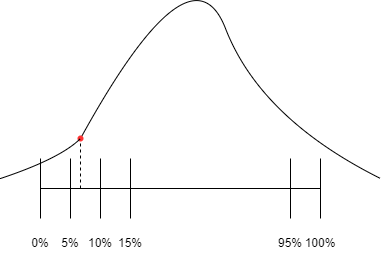
<br>И тогда данная величина будет закодирована следующим вектором:
$$OHE(log(s_i/s_{i-1})) = [0, 1, 0, ..., 0]$$
<br> код ниже выполняет поставленную цель

In [ ]:
# get the one hot encoder for logs

def percentile_encoder_generator():
  data = fin.download(
        tickers = LSTM_tickers, 
        period = LSTM_period,
        group_by = 'ticker'
    )

  # получение логарифмов отношения текущей цены к предыдущей
  all_logs = []
  for ticker_ in LSTM_tickers:
    df = data.loc[:, ticker_]
    # times = df.index
    closed = df.Close

    last_price = closed[0]
    for value in closed[1:]:
      all_logs.append(np.log(value / last_price))
      last_price = value

  all_logs = np.array(all_logs)
  all_logs = (all_logs - all_logs.mean()) / all_logs.std()

  # сам процесс дискретизации полученных логарифмов.
  # get numbers for discretizising log values
  percentiles = list(range(5, 100, 5))
  percentile_values = np.percentile(all_logs, percentiles)
  one_hot_encoder_size = percentile_values.shape[0]
  percentile_values[-1] = 10
  def percentile_encoder(x):
    new_shape = list(x.shape)
    new_shape[-1] = one_hot_encoder_size
    eye = torch.eye(one_hot_encoder_size)[np.argmax(-x.cpu().numpy() + percentile_values > 0, axis=-1).flatten()]
    encode = eye.reshape(new_shape)
    return encode.to(device)
  return percentile_encoder, percentile_values

encoder, percentile_values = percentile_encoder_generator()

# test encoder
print(f"Percentile values: {percentile_values}")

train_loader = DataLoader(StockDataset(), batch_size=LSTM_batch_size, shuffle=True)
for i in islice(train_loader, 1):
  print(f"one-hot-encoded Tensor: {encoder(i[0])[0][:5]}\n\n for value: {i[0][0][:5]}")

[*********************100%***********************]  9 of 9 completed
Percentile values: [-1.50737313e+00 -1.01338263e+00 -7.49560986e-01 -5.53102698e-01
 -4.07460185e-01 -3.00893443e-01 -2.10254144e-01 -1.32658201e-01
 -6.53473406e-02  4.55028255e-03  7.11300211e-02  1.49495986e-01
  2.35280584e-01  3.36791170e-01  4.40983656e-01  5.68739033e-01
  7.28949878e-01  9.73167053e-01  1.00000000e+01]
[*********************100%***********************]  9 of 9 completed
one-hot-encoded Tensor: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.]], device='cuda:0')

 for value: ten

#### Lightning for general LSTM

For exploitation and research purposes, code for external LSTM learning is packed inside pytorch lightning module.

In [ ]:
class LSTMStock(nn.Module):
  def __init__(self, feature_size, hidden_size):
    super(LSTMStock, self).__init__()
    self.feature_size = feature_size
    self.hidden_size = hidden_size

    self.rnn = nn.LSTM(feature_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, feature_size)

  def forward(self, input):
    h, output = self.rnn(input)
    output = output[0][0]
    return self.out(output)

class LitLSTM(pl.LightningModule):
  def __init__(
      self, 
      ohe,
      feature_size=LSTM_feature_size, 
      hidden_size=LSTM_hidden):
    super().__init__()
    self.model = LSTMStock(feature_size, hidden_size)
    self.criterion = nn.CrossEntropyLoss()
    self.encoder = ohe

  def training_step(self, batch, batch_idx):
    x, y = (map(self.encoder, batch))
    out = self.model(x)
    loss = self.criterion(out, y)
    self.log("train loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = (map(self.encoder, batch))
    out = self.model(x)
    loss = self.criterion(out, y)
    self.log("val_loss", loss)

  def predict_step(self, batch, batch_idx):
    x = (map(self.encoder, batch))
    out = self.model(x)
    return out

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    # scheduler = 
    return optimizer

#### acquire model
(model is already trained, code disabled)

In [ ]:
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# model = LitLSTM(encoder)
# train_loader = DataLoader(StockDataset(), batch_size=LSTM_batch_size, shuffle=True)
# val_loader = DataLoader(StockDataset(train=False), batch_size=LSTM_batch_size, shuffle=True)

# # Можно добавить ерли стопинг, но он плохо работает в данной задаче, потому что обучение не стабильно.
# trainer = pl.Trainer(max_epochs=20, default_root_dir=model_checkpoint_path, accelerator="gpu", devices=1)#, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
# trainer.fit(model, train_loader, val_loader)

In [ ]:
# trainer.validate(model, val_loader)

Ниже можно подключить TensorBoard для просмотра результатов тренировки в онлайне.

In [ ]:
# # Load the TensorBoard notebook extension
# %reload_ext tensorboard
# %tensorboard --logdir '/tmp/'

#### load model

In [ ]:
# validate if model is loadeble
model = LitLSTM(encoder)
version_number = 0
if os.path.exists(general_lstm_checkpoint):
  checkpoint = torch.load(general_lstm_checkpoint)
  model.load_state_dict(checkpoint["state_dict"])

#### model eval

In [ ]:
class SimpleLSTMDataset(Dataset):
  def __init__(
      self, 
      ticker=ticker, 
      period=LSTM_period, 
      seq_len=LSTM_seq_len,
      test_size=0.1,
      train=True,
  ):
    super(StockDataset, self).__init__()
    self.data_raw = fin.Ticker(ticker).history(period=period)
    self.seq_len = seq_len
    
    train_slice = slice(0, int(self.data_raw.shape[0] * (1 - test_size)))
    test_slice = slice(int(self.data_raw.shape[0] * (1 - test_size)) - self.seq_len, self.data_raw.shape[0])
    self.data_slice = train_slice if train == True else test_slice

    # get mean and std from dataset for train
    self.all_logs = []
    closed = self.data_raw.Close[train_slice]
    last_price = closed[0]
    for value in closed[1:]:
      self.all_logs.append(np.log(value / last_price))
      last_price = value

    # рассчитаем среднее и стандартное отклонение на тренировочной выборке
    self.mean = np.mean(self.all_logs)
    self.std = np.mean(self.all_logs)

    def log_iterator(df, seq_len, slice_):
      '''
      helps to iterate through dataframe, generating items of resulting
      dataset values (in this case this is concatenated one-hot-encoded values
      of current log, and prediction of LSTM for this log, which represents 
      the next value)
      '''
      times = df.index[slice_]
      closed = df.Close[slice_]

      seq = deque()
      last_price = closed[0]
      for time, value in zip(times[1:seq_len + 2], closed[1:seq_len + 2]):
        log = (np.log(value / last_price) - self.mean) / self.std
        seq.append(log)
        last_price = value
      yield list(seq), list(seq)[-1]

      for time, value in zip(times[seq_len + 2:], closed[seq_len + 2:]):
        log = (np.log(value / last_price) - self.mean) / self.std
        seq.append(log)
        last_price = value
        seq.popleft()
        yield list(seq), list(seq)[-1]

    self.data = []
    self.labels = []
    for seq, label in log_iterator(self.data_raw, seq_len, train_slice if train == True else test_slice):
      self.data.append(seq)
      self.labels.append(label)

    self.data = torch.Tensor(self.data).to(device).unsqueeze(-1)
    self.labels = torch.Tensor(self.labels).to(device)
    self.labels = self.labels.unsqueeze(-1)
    self.len = self.data.shape[0]

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

  def __len__(self):
    return self.len

In [ ]:
model.model.to(device)

LSTMStock(
  (rnn): LSTM(19, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=19, bias=True)
)

[*********************100%***********************]  9 of 9 completed


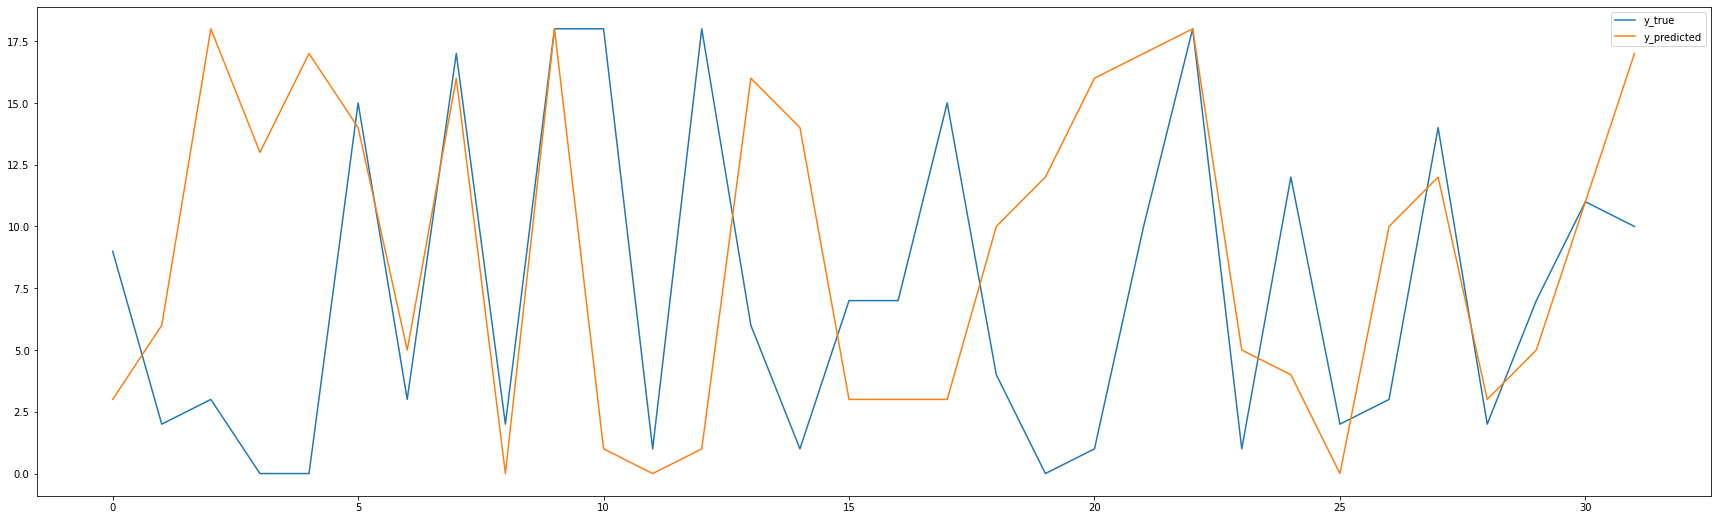

In [ ]:
test_loader = DataLoader(StockDataset(train=False), batch_size=LSTM_batch_size, shuffle=True)
yhat = torch.zeros((0)).to(device)
y = torch.zeros((0)).to(device)
for batch_idx, batch in enumerate(islice(test_loader, 1)):
  y = torch.cat((y, torch.argmax(model.encoder(batch[1]), axis=-1).squeeze()))
  # print(torch.argmax(model.model(model.encoder(batch[0])), axis=-1))
  # print(torch.argmax(model.encoder(batch[1]), axis=-1))
  yhat = torch.cat((yhat, torch.argmax(model.model(model.encoder(batch[0])), axis=-1)))

plt.subplots(figsize=(30, 9))
plt.plot(y.detach().cpu(), label="y_true")
plt.plot(yhat.detach().cpu(), label="y_predicted")
plt.legend()

 ### Environment definition 🌳

Данные будут предобрабатываться следующий образом: на диаграмме, $\widehat{close_{i+1}}$ - не известны на текущем шаге, и для их аппроксимации используется внешная general purpose LSTM. 

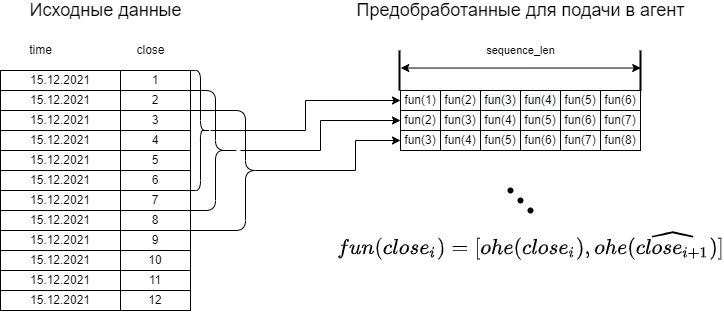

In [ ]:
class Env():
  def __init__(
      self,
      ticker=ticker, 
      period=period, 
      seq_len=seq_len, 
      gamma=discount, 
      portfolio=initial_sum, 
      trading_size=trading_size,
      test_size=0,
      test=False,
      LSTM_fe_location=general_lstm_checkpoint,
      gamma_trading=0.5, 
      use_CC = False,
    ):
    # Possible place for adding some technical indicators
    # time and action features (source)[https://github.com/conditionWang/DRQN_Stock_Trading]
    self.data_raw = fin.Ticker(ticker).history(period=period)
    self.gamma_trading=gamma_trading
    self.initial_sum = initial_sum
    self.portfolio = [initial_sum]
    self.trading_size = trading_size
    self.seq_len = seq_len
    self.spread = 0.005
    self.gamma = gamma
    self.pointer = 0
    self.test_size = test_size
    self.test = test
    self.ticker = ticker
    self.period = period
    self.use_CC = use_CC

# Part for feature extractor
    # get one hot encoder for logs:
    ohe, percentile_values = percentile_encoder_generator()
    
    # по сути внешняя LSTM выступает генератором фичей для этой.
    # load feature extractor lstm
    model = LitLSTM(ohe=ohe)
    version_number = 0
    if os.path.exists(LSTM_fe_location):
      checkpoint = torch.load(LSTM_fe_location)
      model.load_state_dict(checkpoint["state_dict"])
    else:
      raise "Not found checkpoint"

    train_slice = slice(0, int(self.data_raw.shape[0] * (1 - test_size)))
    test_slice = slice(int(self.data_raw.shape[0] * (1 - test_size)) - self.seq_len, self.data_raw.shape[0])
   
    # get mean and std from dataset for train
    self.all_logs = []
    closed = self.data_raw.Close[train_slice]
    last_price = closed[0]
    for value in closed[1:]:
      self.all_logs.append(np.log(value / last_price))
      last_price = value

    # рассчитаем среднее и стандартное отклонение на тренировочной выборке
    self.mean = np.mean(self.all_logs)
    self.std = np.mean(self.all_logs)

    # получаем полную выборку всех логов, для скармливания в нейронную сеть
    self.all_logs = []
    closed = self.data_raw.Close
    last_price = closed[0]
    for value in closed[1:]:
      self.all_logs.append(np.log(value / last_price))
      last_price = value
    # size(self.all_logs) == [n, ] - обычный массив с логарифмами значений

    # нормализуем выборку
    self.all_logs = np.array(self.all_logs)
    self.all_logs = (self.all_logs - self.all_logs.mean()) / self.all_logs.std()

    # получаем признаки из нейронной сети для предсказания короткой торговли
    data_for_lstm = []
    for i in range(LSTM_seq_len, self.all_logs.shape[0] + 1):
      data_for_lstm.append(self.all_logs[i - LSTM_seq_len:i])

    # data_for_lstm.shape == (n - LSTM_seq_len, LSTM_seq_len, )
    data_for_lstm = torch.Tensor(data_for_lstm).unsqueeze(-1)
    # data_for_lstm.shape == (1, n - LSTM_seq_len, LSTM_seq_len,)

    model.model.to(device) #  переводим модель на куду если она enable
    results = nn.functional.softmax(model.model(ohe(data_for_lstm)), dim=-1)
    results = results.cpu().detach().numpy()
    results = np.concatenate((np.zeros((LSTM_seq_len, LSTM_feature_size)), results), axis=0)
    self.lstm_features = results
    # Получеаем значения, предсказанные General Purpose LSTM для наших данных.

    # self.lstm_features.shape == (self.data_raw.Close.shape[0], LSTM_feature_size)
    # for every closed price lstm feature is generated
# Part for feature extractor

    def log_iterator(df, lstm_features, seq_len, slice_):
      '''
      helps to iterate through dataframe, generating items of resulting
      dataset values (in this case this is concatenated one-hot-encoded values
      of current log, and prediction of LSTM for this log, which represents 
      the next value)
      '''
      # задача этого куска кода сделать удобным трансформацию датафрейма, состоящего
      # из close прайсов на каждый день, в следующий формат:
      # lstm_feature = ([0,..,1,0,...0, 0,..,1,0,...0]) == [(ohe от log), (features из GP LSTM (тоже ohe, но для следующего log))]
      # На вход нашей сети, следовательно мы должны подавать [lstm_feature_(-n), lstm_feature_(-n + 1), ..., lstm_feature_(0)], размерностью [n, 20 + 20 (ohe от 2 значений)]

      times = df.index[slice_]
      closed = df.Close[slice_]
      lstm_features = lstm_features[slice_]

      seq = deque()
      last_price = closed[0]
      for time, value, feature in zip(times[1:seq_len + 1], closed[1:seq_len + 1], lstm_features[1:seq_len + 1]):
        log = (np.log(value / last_price) - self.mean) / self.std
        seq.append(np.hstack((ohe(torch.tensor([log])).cpu(), feature)))
        # np.hstack((ohe(torch.tensor([log])).cpu(), feature)) ====> [lstm_feature_(-n), lstm_feature_(-n + 1), ..., lstm_feature_(0)]
        last_price = value
      yield list(seq)

      for time, value, feature in zip(times[seq_len + 1:-1], closed[seq_len + 1:-1], lstm_features[seq_len + 1:-1]):
        log = (np.log(value / last_price) - self.mean) / self.std
        seq.append(np.hstack((ohe(torch.tensor([log])).cpu(), feature)))
        last_price = value
        seq.popleft()
        # тут мы как раз отдаем [lstm_feature_(-n), lstm_feature_(-n + 1), ..., lstm_feature_(0)]
        yield list(seq)

    self.data = []
    for seq in log_iterator(self.data_raw, self.lstm_features, self.seq_len, train_slice if test == False else test_slice):
      self.data.append(seq)

    # в self.data мы имеем полученный датасет.
    self.data = torch.Tensor(self.data)
    self.data = self.data.to(device)
    self.closed = self.data_raw.Close[train_slice if test == False else test_slice]
    self.len = self.data.shape[0]

  def step(self, action, CC):
    """returns reward r"""
    actions = [-1, 0, 1]
    a = actions[action]
    v_old = self.portfolio[-1]

    current_closed = self.closed[self.pointer + self.seq_len - 1]
    next_closed = self.closed[self.pointer + self.seq_len]

    
    v_new = 0
    if self.use_CC: # проверка использования коэффициента уверенности, использование может затруднить обучение
      step = a * CC * self.gamma_trading * v_old
      v_new = v_old - step + step * next_closed / current_closed# - commission
    else:
      v_new = v_old - a * self.trading_size + a * self.trading_size * next_closed / current_closed# - commission

    if v_new * v_old > 0:
      reward = np.log(v_new / v_old)
    else:
      reward = -1
    self.portfolio.append(v_new)
    return reward

  def reset(self):
    self.pointer = 0
    self.portfolio = [self.initial_sum]

  def get_next(self):
    """returns next state s' """
    if self.pointer < self.len:
      next = self.data[self.pointer]
      self.pointer += 1
      return next
    else:
      return None

### Main training cicle

##### Function for training

In [ ]:
def train_model():
  agent = Agent()
  train_env = Env(test_size=test_size)
  test_env = Env(test_size=test_size, test=True)
  agent.set_decay(train_env.len * 10)

  best_portfolio = [0]
  iter = 0
  for t in (range(400)):
    agent.set_eval(False)
    train_env.reset()
    actions = []
    loss = []
    rewards = []
    current_state = train_env.get_next()
    next_state = current_state
    with tqdm(range(1, train_env.len)) as pbar:
      pbar.set_description(f"Train episode {t}")
      for i in pbar:
        iter += 1
        action, confidence = agent.act(current_state)
        actions.append(action)
        rewards.append(train_env.step(action, confidence))
        next_state = train_env.get_next()
        agent.store(current_state, action, next_state, rewards[-1])
        loss.append(agent.optimize())

        current_state = next_state
        if i % ((train_env.len - train_env.seq_len) // 10) == 0:
          pbar.set_postfix(loss=loss[-1], reward=rewards[-1], portfolio=train_env.portfolio[-1], actions=Counter(actions))
        if iter % policy_to_target_step == 0:
          agent.policy_to_target()

      if loss[0] is None:
        loss = loss[batch_size:]
      pbar.set_postfix(loss_sum=np.sum(loss), reward_sum=np.sum(rewards), portfolio=train_env.portfolio[-1], actions=Counter(actions))

    agent.opt_scheduler.step()

    if (t + 1) % 10 == 0: # каждые 10 итераций сохраняем стейт модели
      print("progress saved")
      torch.save(agent.policy_net.to('cpu').state_dict(), model_checkpoint_path + f"policy_net_cpu{ticker}_{period}_{hidden_size}.pkl")
      torch.save(agent.policy_net.to(device).state_dict(), model_checkpoint_path + f"policy_net_gpu{ticker}_{period}_{hidden_size}.pkl")
      torch.save(agent.optimizer.state_dict(), model_checkpoint_path + f"optimizer{ticker}_{period}_{hidden_size}.pkl")

    if best_portfolio[-1] < train_env.portfolio[-1]:  # если модель сделала наибольшее портфолио, сохраняем ее с меткой лучшая.
      # if results are the best, then save current version of network
      best_portfolio = train_env.portfolio
      torch.save(agent.policy_net.to('cpu').state_dict(), model_checkpoint_path + f"best_policy_net_cpu{ticker}_{period}_{hidden_size}.pkl")
      torch.save(agent.policy_net.to(device).state_dict(), model_checkpoint_path + f"best_policy_net_gpu{ticker}_{period}_{hidden_size}.pkl")
      torch.save(agent.optimizer.state_dict(), model_checkpoint_path + f"best_optimizer{ticker}_{period}_{hidden_size}.pkl")

    # test agent
    if (t + 1) % 5 == 0:
      agent.set_eval(True)
      test_env.reset()
      actions = []
      rewards = []
      current_state = test_env.get_next()
      next_state = current_state
      with tqdm(range(1, test_env.len)) as pbar:
        pbar.set_description("Test")
        for i in pbar:
        # while next_state is not None:
          action, confidence = agent.act(current_state)
          actions.append(action)
          rewards.append(test_env.step(action, confidence))
          next_state = test_env.get_next()

          current_state = next_state
          if i % (test_env.len // 3) == 0:
            pbar.set_postfix(reward=rewards[-1], portfolio=test_env.portfolio[-1], actions=Counter(actions))
        pbar.set_postfix(reward_sum=np.sum(rewards), portfolio=train_env.portfolio[-1], actions=Counter(actions))

##### Training

In [ ]:
train_model()

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed



Train episode 0: 100%|██████████| 742/742 [00:05<00:00, 146.25it/s, actions=Counter({2: 229, 0: 227, 1: 224}), loss=4.83e-6, portfolio=8.7e+5, reward=-.000392]

Train episode 1: 100%|██████████| 742/742 [00:07<00:00, 96.79it/s, actions=Counter({1: 253, 0: 225, 2: 202}), loss=8.97e-6, portfolio=1.04e+6, reward=-.00033] 

Train episode 2: 100%|██████████| 742/742 [00:05<00:00, 136.73it/s, actions=Counter({2: 238, 0: 221, 1: 221}), loss=1.39e-6, portfolio=9.58e+5, reward=-.000356]

Train episode 3: 100%|██████████| 742/742 [00:05<00:00, 136.94it/s, actions=Counter({2: 244, 0: 239, 1: 197}), loss=7.89e-7, portfolio=8.86e+5, reward=-.000385]

Train episode 4: 100%|██████████| 742/742 [00:08<00:00, 90.85it/s, actions=Counter({2: 244, 1: 232, 0: 204}), loss=2.66e-6, portfolio=1.05e+6, reward=-.000323]

Test: 100%|██████████| 200/200 [00:00<00:00, 457.73it/s, actions=Counter({1: 134}), portfolio=1e+6, reward=0]

Train episode 5: 100%|██████████| 742/742 [00:05<00:00, 123.70it/s, actions=Count

progress saved



Test: 100%|██████████| 200/200 [00:00<00:00, 652.35it/s, actions=Counter({2: 128, 1: 5, 0: 1}), portfolio=9.81e+5, reward=0.00125]

Train episode 10: 100%|██████████| 742/742 [00:05<00:00, 128.93it/s, actions=Counter({2: 293, 0: 210, 1: 177}), loss=2.74e-6, portfolio=1.14e+6, reward=0]

Train episode 11: 100%|██████████| 742/742 [00:05<00:00, 124.02it/s, actions=Counter({2: 272, 0: 225, 1: 183}), loss=1.84e-6, portfolio=1.19e+6, reward=0.000287]

Train episode 12: 100%|██████████| 742/742 [00:06<00:00, 123.55it/s, actions=Counter({2: 286, 0: 221, 1: 173}), loss=7.57e-7, portfolio=1.07e+6, reward=0.000319]

Train episode 13: 100%|██████████| 742/742 [00:06<00:00, 122.26it/s, actions=Counter({2: 299, 0: 214, 1: 167}), loss=2.13e-6, portfolio=1.16e+6, reward=0.000295]

Train episode 14: 100%|██████████| 742/742 [00:06<00:00, 120.45it/s, actions=Counter({2: 323, 0: 218, 1: 139}), loss=2.21e-6, portfolio=1.16e+6, reward=-.000295]

Test: 100%|██████████| 200/200 [00:00<00:00, 602.05it/s, ac

progress saved



Test: 100%|██████████| 200/200 [00:00<00:00, 647.45it/s, actions=Counter({2: 120, 0: 14}), portfolio=9.69e+5, reward=0.00127]

Train episode 20: 100%|██████████| 742/742 [00:06<00:00, 121.42it/s, actions=Counter({2: 352, 0: 200, 1: 128}), loss=2.5e-6, portfolio=1.32e+6, reward=0.000258]

Train episode 21: 100%|██████████| 742/742 [00:06<00:00, 119.83it/s, actions=Counter({2: 315, 0: 253, 1: 112}), loss=2.48e-6, portfolio=1.28e+6, reward=0]

Train episode 22: 100%|██████████| 742/742 [00:06<00:00, 120.51it/s, actions=Counter({2: 339, 0: 199, 1: 142}), loss=3.15e-6, portfolio=1.37e+6, reward=0.00025]

Train episode 23: 100%|██████████| 742/742 [00:06<00:00, 116.40it/s, actions=Counter({2: 311, 0: 225, 1: 144}), loss=2.93e-6, portfolio=1.25e+6, reward=0.000273]

Train episode 24: 100%|██████████| 742/742 [00:06<00:00, 117.45it/s, actions=Counter({2: 318, 0: 225, 1: 137}), loss=1.73e-6, portfolio=1.3e+6, reward=0.000263]

Test: 100%|██████████| 200/200 [00:00<00:00, 572.22it/s, actions=Co

KeyboardInterrupt: ignored

### Model Evaluation

#### function for evaluation

In [ ]:
def eval_models(ticker_, period_, chk_pth = None):
  ''' 
      train/eval stage specific variables
    
      v    v   v          v    v  
    AAPL AMD AMZN GOOGL META MSFT XOM 
    3y   3y  4y   3y    4y   2y   8y

    models that have been yet trained are marked by v symbol

    change underlying variables to load and eval proper models
  '''

  list_of_trades = defaultdict(list)
  list_of_trades["cum_profit"].append(initial_sum) # simple hack for simplicity

  # Загрузка агента
  agent = Agent()
  if chk_pth == None:
    chk_pth = artifacts_path + f"{ticker_}_{period_}_{hidden_size}.pkl"
  agent.policy_net.load_state_dict(torch.load(chk_pth))
  agent.policy_to_target()
  agent.policy_net.to(device)
  agent.set_eval(True)

  # установка двух env (тренировочного и тестового). Можно установить 1 env, с test_size=0
  # Для отображения полного интервала торговли, но это сместит mean и std значения,
  # На которых училась сеть, что возможно дестабилизирует обучени.
  train_env = Env(ticker=ticker_, period=period_, test_size=test_size)
  test_env = Env(ticker=ticker_, period=period_, test_size=test_size, test=True)

  counter = 0
  actions = []
  # проходимся по каждому env, собирая статистику как работает агент на train и test
  for env in (train_env, test_env):
    env.reset()
    rewards = []
    with tqdm(range(0, env.len)) as pbar:
      pbar.set_description(f"test")
      for i in pbar:
        # стандартная работа с агентом и env
        current_state = env.get_next()
        action, confidence = agent.act(current_state)
        actions.append(action)
        rewards.append(env.step(action, confidence))

        # Заполняем list of trades
        list_of_trades["time"].append(env.data_raw.index.to_numpy()[env.seq_len - 1 + counter])
        list_of_trades["action"].append(["sell", "hold", "buy"][action])
        list_of_trades["price"].append(env.closed[env.pointer + env.seq_len - 1])
        list_of_trades["cum_profit"].append(env.portfolio[-1])
        list_of_trades["profit"].append(env.portfolio[-1] - env.portfolio[-2])
        list_of_trades["confidence"].append(confidence)
        counter += 1

        if i % 100 == 0:
          pbar.set_postfix(reward=rewards[-1], portfolio=env.portfolio[-1], actions=Counter(actions))
      pbar.set_postfix(reward=rewards[-1], portfolio=env.portfolio[-1], actions=Counter(actions))
    actions.append(1)

  list_of_trades["cum_profit"] = list_of_trades["cum_profit"][1:]

  # Тут довольно сложная логика построения графика
  fig, ax = plt.subplots(1, 3, figsize=(30, 20))

  plt.subplot(211)
  actions_np = np.array(actions)
  actions_to_close = np.array([train_env.data_raw.Close.to_numpy()[train_env.seq_len - 1: -1], np.arange(len(actions))])
  actions_to_close[:, actions_np == 1]
  plt.title("Actions taken on ticker", fontsize=20)
  plt.plot(actions_to_close[1], actions_to_close[0])
  plt.scatter(actions_to_close[1, actions_np == 0], actions_to_close[0, actions_np == 0], color='r', marker='v', s=20)
  plt.scatter(actions_to_close[1, actions_np == 2], actions_to_close[0, actions_np == 2], color='g', marker='^', s=20)

  border_line = ([train_env.len] * 2, [actions_to_close[0].max(), actions_to_close[0].min()])
  plt.plot(*border_line, 'k--', label='Train test split')
  plt.legend(prop={"size":20})

  plt.subplot(223)
  plt.title("Portfolio size on train", fontsize=20)
  plt.plot(train_env.portfolio)

  plt.subplot(224)
  plt.title("Portfolio size on test", fontsize=20)
  plt.plot(test_env.portfolio)

  plt.savefig(f"{ticker_}_{period_}_{hidden_size}.svg", format="svg")

  # Здесь расположен вывод List of trades
  lot = pd.DataFrame(list_of_trades)

  # смысл этой величины в том, что модель с большей уверенностью должна делать предсказания с большой выгодой,
  # и с меньшей уверенностью предсказания с большим риском. Возможно я что то считаю не правильно, 
  # Но насколько я понимаю, хорошим показателем работы моего алгоритма является 
  # то, что эта взвешенная сумма должна быть больше кумулитивного профита за все время.
  print(f"Weighted sum of incomes = {(lot.profit.iloc[:-201] * lot.confidence.iloc[:-201]).sum()}")
  return lot

#### evaluation

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed



test: 100%|██████████| 742/742 [00:03<00:00, 230.93it/s, actions=Counter({2: 431, 1: 169, 0: 101}), portfolio=1.35e+6, reward=0.000802]

test: 100%|██████████| 201/201 [00:00<00:00, 234.85it/s, actions=Counter({2: 581, 1: 233, 0: 130}), portfolio=1.01e+6, reward=0.00312]


Weighted sum of incomes = 248108.28955615556


cum_profit                      time action       price       profit  \
0    9.987993e+05 2019-03-14 00:00:00-04:00    buy  172.272400 -1200.712770   
1    9.989389e+05 2019-03-15 00:00:00-04:00    buy  170.203903   139.585134   
2    9.969261e+05 2019-03-18 00:00:00-04:00    buy  170.441483 -2012.819456   
3    1.001512e+06 2019-03-19 00:00:00-04:00    buy  167.010803  4586.312564   
4    9.991457e+05 2019-03-20 00:00:00-04:00    buy  174.670441 -2366.700614   
..            ...                       ...    ...         ...          ...   
938  1.001395e+06 2022-12-01 00:00:00-05:00    buy  452.600006 -2101.195236   
939  1.001664e+06 2022-12-02 00:00:00-05:00    buy  443.089996   268.569016   
940  1.004077e+06 2022-12-05 00:00:00-05:00    buy  444.279999  2412.893052   
941  1.003022e+06 2022-12-06 00:00:00-05:00    buy  455.000000 -1054.942372   
942  1.006154e+06 2022-12-07 00:00:00-05:00    buy  450.200012  3131.935852   

     confidence  
0      0.564261  
1      0.643283  
2      0.567239  
3      0.615580  
4      0.597210  
..          ...  
938    0.483613  
939    0.525344  
940    0.582091  
941    0.475001  
942    0.463021  

[943 rows x 6 columns]

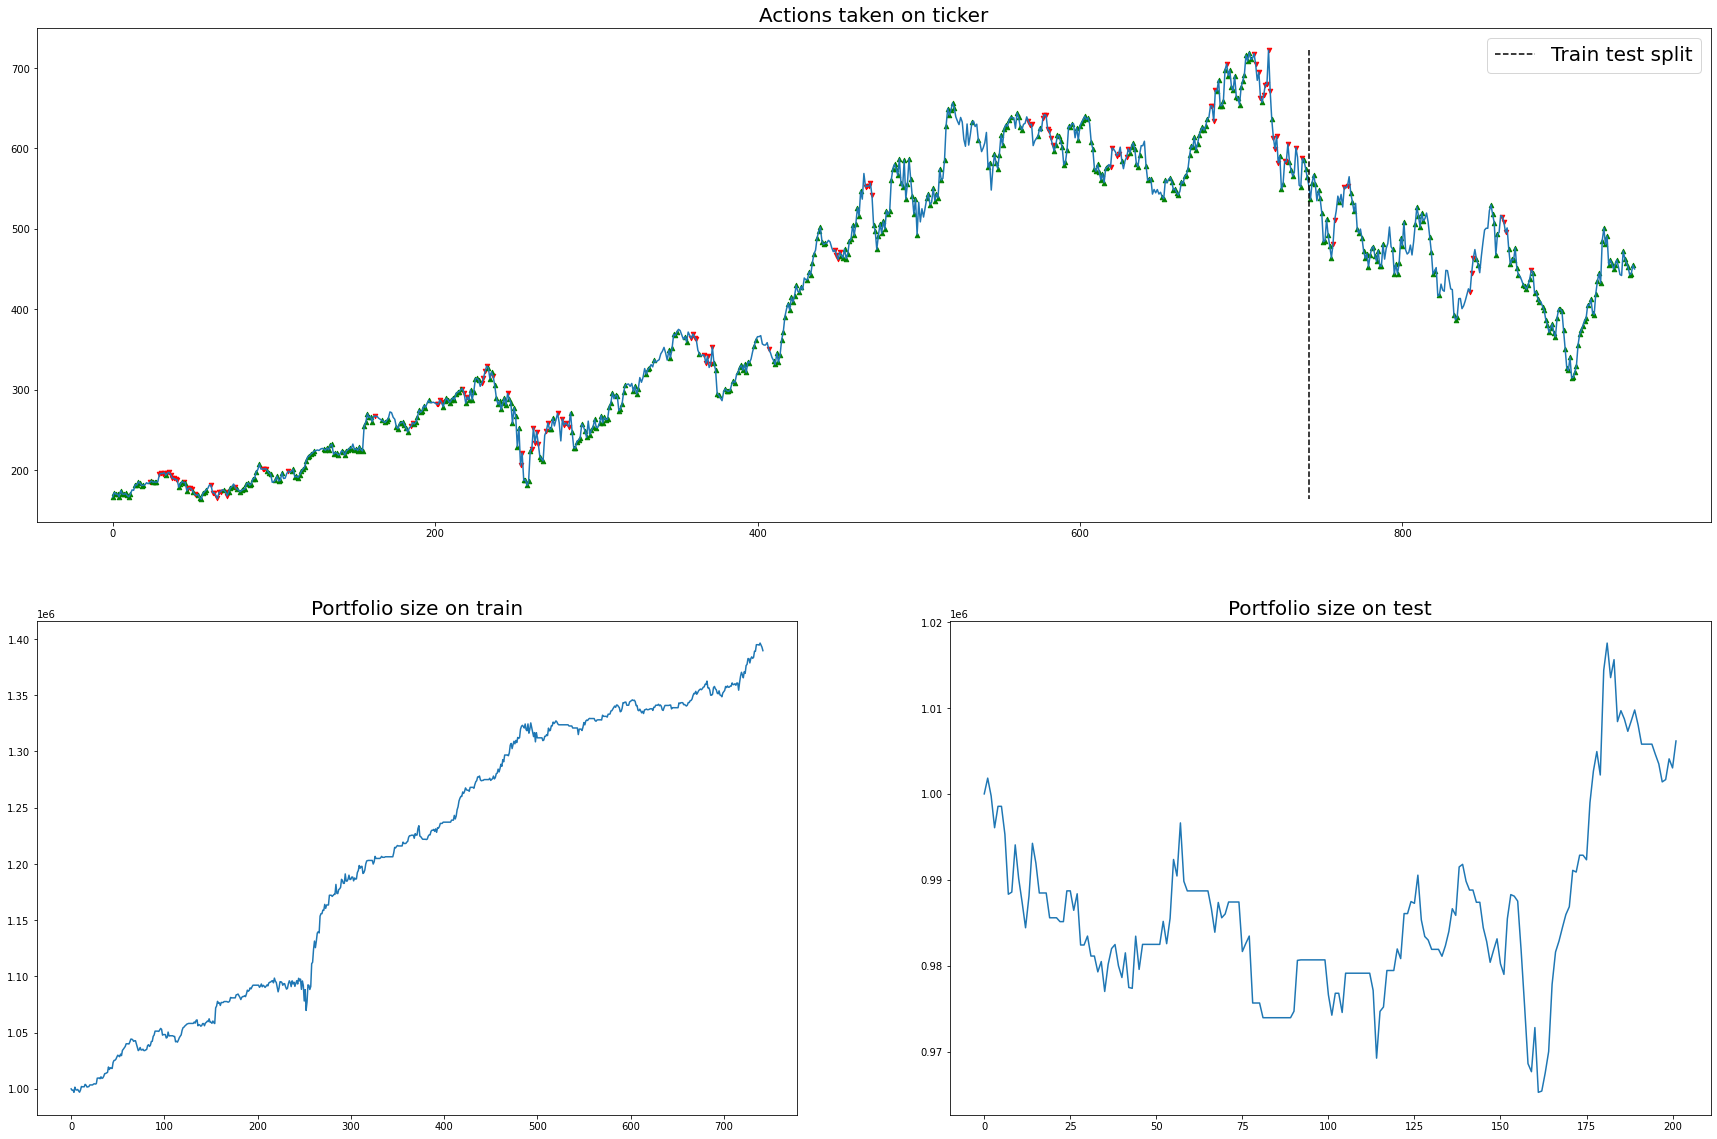

In [ ]:
''' 
train/eval stage specific variables

 v    v   v     v    v    v  
AAPL AMD AMZN GOOGL META MSFT XOM 
3y   3y  4y   3y    4y   2y   8y

models that have been yet trained are marked by v symbol

change underlying variables to load and eval proper models
'''

# В данном примере, сначала была натринирована нейронка под данный тикер. Ее
# артифакты были сложены в папку, указанную ниже как аргумент chk_pth.
eval_ticker = "LRCX"
eval_period = "4y"
eval_models(eval_ticker, eval_period, chk_pth=model_checkpoint_path + f"best_policy_net_cpu{eval_ticker}_{eval_period}_{hidden_size}.pkl")
# Можно конфигурировать chk_pth для агента, но если он не задан, то выберется из
# скачанных с гита, и если там нет, то кинет експешн. Чекпоинт должен быть в cpu векторе.